# 🍽 Sentiment Analysis of Swiggy vs Zomato App Reviews  
### Text Analytics and NLP Project  

---

## 🎯 Objective
To analyze and compare customer sentiment for **Swiggy** and **Zomato** using Play Store reviews.

**Goals**
- Collect and clean user reviews  
- Perform sentiment analysis (Positive / Neutral / Negative)  
- Visualize emotional tone and trends  
- Derive actionable insights for business decisions  

---

## 🧰 Tech Stack
| Category | Tools / Libraries |
|-----------|------------------|
| Data Cleaning | NLTK, spaCy |
| Sentiment Analysis | VADER, TextBlob |
| Visualization | Matplotlib, Seaborn, WordCloud |
| Storage | Pandas, Google Drive |
| Scraping | google-play-scraper |

## 🧩 Step 1: Install and Import Dependencies

Install all the Python packages required for:
- Data collection  
- NLP preprocessing  
- Sentiment scoring  
- Visualization

In [ ]:
!pip -q install google-play-scraper vaderSentiment textblob wordcloud scikit-learn matplotlib seaborn plotly spacy emoji tqdm openpyxl
!python -m spacy download en_core_web_sm -q
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 139.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 💾 Step 2: Mount Google Drive and Create Folder Structure  

Mount Drive to automatically save raw data, cleaned data, plots, and Excel summaries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PROJECT_DIR = Path('/content/drive/MyDrive/Sentiment_Swiggy_Zomato')
PLOTS_DIR   = PROJECT_DIR / 'plots'
PROJECT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved to: {PROJECT_DIR}")

All outputs will be saved to: /content/drive/MyDrive/Sentiment_Swiggy_Zomato


## ⚙ Step 3: Import Libraries and Set Global Parameters  

Import all key packages and define:
- Random seed for reproducibility  
- Date filter (last 180 days)  
- Default visualization style

In [ ]:
import re, math, time, json, datetime as dt
from datetime import datetime, timedelta
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from emoji import demojize
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Choose lookback window (e.g., last 180 days)
LOOKBACK_DAYS = 180
SINCE_DATE = datetime.utcnow() - timedelta(days=LOOKBACK_DAYS)

# Play Store country/lang for India English
PLAY_LANG = 'en'
PLAY_COUNTRY = 'in'

/tmp/ipython-input-2269909875.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  SINCE_DATE = datetime.utcnow() - timedelta(days=LOOKBACK_DAYS)


## 🆔 Step 4: Define App IDs  

Specify Play Store IDs for both Swiggy and Zomato.  
(Found after `id=` in each app’s Play Store URL.)

In [ ]:
# Known app IDs (change if Play Store IDs differ)
APP_IDS = {
    "Swiggy":  "in.swiggy.android",     # fallback alt some use: "com.swiggy.android"
    "Zomato":  "com.application.zomato"
}

print(APP_IDS)

{'Swiggy': 'in.swiggy.android', 'Zomato': 'com.application.zomato'}


## 🤖 Step 5: Create Review Scraper Functions  

Functions include:
- Verify app details  
- Fetch reviews in multiple batches  
- Convert raw JSON to DataFrame  

In [ ]:
from google_play_scraper import Sort, reviews, app

def verify_app(app_id):
    """Return dict with app metadata to ensure the ID is valid."""
    try:
        meta = app(app_id, lang=PLAY_LANG, country=PLAY_COUNTRY)
        return {"ok": True, "title": meta.get("title"), "score": meta.get("score"),
                "installs": meta.get("installs")}
    except Exception as e:
        return {"ok": False, "error": str(e)}

def fetch_reviews(app_id, max_reviews=5000, sort=Sort.NEWEST, sleep_sec=0.7):
    """
    Paginate through reviews() to collect up to max_reviews.
    Returns a list of dicts with: content, score, at (datetime), userName, replyContent, thumbsUpCount.
    """
    all_reviews = []
    token = None
    pbar = tqdm(total=max_reviews, desc=f"Fetching {app_id}", unit="rev")
    while len(all_reviews) < max_reviews:
        try:
            batch, token = reviews(
                app_id,
                lang=PLAY_LANG,
                country=PLAY_COUNTRY,
                sort=sort,
                count=200,
                continuation_token=token
            )
        except Exception as e:
            print(f"[WARN] Error fetching: {e}. Retrying in 5s...")
            time.sleep(5)
            continue

        if not batch:
            break

        all_reviews.extend(batch)
        pbar.update(len(batch))
        if token is None:
            break
        time.sleep(sleep_sec)  # be polite
    pbar.close()
    return all_reviews[:max_reviews]

def to_dataframe(raw, app_name):
    rows = []
    for r in raw:
        rows.append({
            "app": app_name,
            "review": r.get("content","") or "",
            "stars": r.get("score"),
            "at": r.get("at"),
            "userName": r.get("userName"),
            "thumbsUpCount": r.get("thumbsUpCount", 0),
            "replyContent": r.get("replyContent")
        })
    return pd.DataFrame(rows)

## 📥 Step 6: Fetch Reviews for Both Apps  

Fetch recent reviews for Swiggy and Zomato using the scraper, then save them as CSV files.

In [ ]:
MAX_PER_APP = 6000  # adjust as you like

# 1) Verify IDs
for name, app_id in APP_IDS.items():
    check = verify_app(app_id)
    print(name, "→", check)

# 2) Fetch & convert
dfs = []
for name, app_id in APP_IDS.items():
    raw = fetch_reviews(app_id, max_reviews=MAX_PER_APP, sort=Sort.NEWEST)
    df  = to_dataframe(raw, name)
    dfs.append(df)
    out_path = PROJECT_DIR / f"{name.lower()}_raw_reviews.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved raw: {out_path} ({len(df):,} rows)")

raw_all = pd.concat(dfs, ignore_index=True)

# 3) Filter by since date (lookback window)
raw_all = raw_all[raw_all["at"] >= SINCE_DATE].copy()
print(f"After date filter (since {SINCE_DATE.date()}): {len(raw_all):,} rows total")

# 4) Save filtered snapshot
filtered_path = PROJECT_DIR / "reviews_filtered.csv"
raw_all.to_csv(filtered_path, index=False)
print(f"Saved filtered reviews → {filtered_path}")

Swiggy → {'ok': True, 'title': 'Swiggy: Food Instamart Dineout', 'score': 4.483624, 'installs': '100,000,000+'}
Zomato → {'ok': True, 'title': 'Zomato: Food Delivery & Dining', 'score': 4.5502667, 'installs': '100,000,000+'}


Fetching in.swiggy.android: 100%|██████████| 6000/6000 [00:29<00:00, 203.24rev/s]


Saved raw: /content/drive/MyDrive/Sentiment_Swiggy_Zomato/swiggy_raw_reviews.csv (6,000 rows)


Fetching com.application.zomato: 100%|██████████| 6000/6000 [00:29<00:00, 206.00rev/s]

Saved raw: /content/drive/MyDrive/Sentiment_Swiggy_Zomato/zomato_raw_reviews.csv (6,000 rows)
After date filter (since 2025-04-09): 12,000 rows total
Saved filtered reviews → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/reviews_filtered.csv


## 🧹 Step 7: Clean and Preprocess Text  

Perform:
- Lowercasing  
- Removal of punctuation, emojis, URLs  
- Lemmatization using spaCy  
- Stopword removal  

Output: clean text ready for sentiment analysis.

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

url_re = re.compile(r'(https?://\S+|www\.\S+)')
html_re = re.compile(r'<.*?>')
nonalpha_re = re.compile(r'[^a-z\s]')

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = demojize(t)                  # 🙂 -> :slightly_smiling_face:
    t = t.lower()
    t = re.sub(html_re, ' ', t)
    t = re.sub(url_re, ' ', t)
    t = re.sub(r'[\r\n\t]+', ' ', t)
    t = re.sub(nonalpha_re, ' ', t)  # keep only letters + spaces
    doc = nlp(t)
    tokens = []
    for tok in doc:
        if tok.is_space:
            continue
        w = tok.lemma_
        if (w in STOP_WORDS) or (len(w) <= 2):
            continue
        tokens.append(w)
    return " ".join(tokens)

clean_df = raw_all.copy()
clean_df["review_clean"] = clean_df["review"].astype(str).apply(clean_text)
clean_df["char_len"] = clean_df["review"].astype(str).str.len()
clean_df["word_len"] = clean_df["review_clean"].str.split().apply(len)

# Drop empties after cleaning
clean_df = clean_df[clean_df["review_clean"].str.strip().str.len() > 0].copy()

cleaned_path = PROJECT_DIR / "reviews_clean.csv"
clean_df.to_csv(cleaned_path, index=False)
print(f"Saved cleaned reviews → {cleaned_path} ({len(clean_df):,} rows)")

Saved cleaned reviews → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/reviews_clean.csv (11,799 rows)


## 💬 Step 8: Sentiment Analysis (VADER + TextBlob)  

Apply two methods:
- VADER (rule-based sentiment)
- TextBlob (lexicon-based sentiment)

Assign sentiment labels and compare with star ratings.

In [ ]:
sid = SentimentIntensityAnalyzer()

def vader_sentiment_label(text):
    s = sid.polarity_scores(text)["compound"]
    if s >= 0.05:
        return "positive"
    elif s <= -0.05:
        return "negative"
    return "neutral"

def textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

# Compute
clean_df["vader_compound"] = clean_df["review"].astype(str).apply(lambda x: sid.polarity_scores(x)["compound"])
clean_df["vader_label"]    = clean_df["review"].astype(str).apply(vader_sentiment_label)
clean_df["tb_polarity"]    = clean_df["review"].astype(str).apply(textblob_polarity)

# Optional: derive a 3-class label from stars to compare against sentiment
def stars_to_label(stars):
    if stars is None or math.isnan(stars):
        return None
    if stars >= 4:
        return "positive"
    elif stars <= 2:
        return "negative"
    return "neutral"

clean_df["stars_label"] = clean_df["stars"].apply(stars_to_label)

scored_path = PROJECT_DIR / "reviews_scored.csv"
clean_df.to_csv(scored_path, index=False)
print(f"Saved scored reviews → {scored_path}")

Saved scored reviews → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/reviews_scored.csv


## 📊 Step 9: Generate Sentiment Summaries and Export Results  

Aggregate sentiment counts for each app and export to:
- CSV files  
- Excel workbook  
- Actionable summary table

In [ ]:
# Sentiment distribution per app
sent_dist = (clean_df
             .groupby(["app","vader_label"])
             .size()
             .reset_index(name="count"))
# Use transform to calculate the share with the correct index alignment
sent_dist["share"] = sent_dist.groupby("app")["count"].transform(lambda x: x/x.sum())

# Compare VADER vs star labels (agreement)
agree_df = clean_df.dropna(subset=["stars_label"]).copy()
agree_df["agree"] = (agree_df["vader_label"] == agree_df["stars_label"]).astype(int)
agreement = agree_df.groupby("app")["agree"].mean().reset_index()
agreement.rename(columns={"agree":"vader_vs_star_agreement"}, inplace=True)

summary_path = PROJECT_DIR / "summary_sentiment.csv"
sent_dist.to_csv(summary_path, index=False)

# Excel with multiple sheets
excel_path = PROJECT_DIR / "project_outputs.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    clean_df.to_excel(writer, index=False, sheet_name="All_Reviews")
    sent_dist.to_excel(writer, index=False, sheet_name="Sentiment_Distribution")
    agreement.to_excel(writer, index=False, sheet_name="Agreement")

print(f"Saved summary CSV → {summary_path}")
print(f"Saved Excel workbook → {excel_path}")
sent_dist.head(), agreement

Saved summary CSV → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/summary_sentiment.csv
Saved Excel workbook → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/project_outputs.xlsx


(      app vader_label  count     share
 0  Swiggy    negative   1441  0.245737
 1  Swiggy     neutral    877  0.149557
 2  Swiggy    positive   3546  0.604707
 3  Zomato    negative    720  0.121314
 4  Zomato     neutral    781  0.131592,
       app  vader_vs_star_agreement
 0  Swiggy                 0.772510
 1  Zomato                 0.805729)

## 🎨 Step 10: Visualize Sentiment and Polarity  

Visualize:
- Sentiment distribution (bar chart)  
- Polarity distribution (boxplot)  
- Stars vs Sentiment correlation (scatter plot)

Saved plot → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/plots/sentiment_share_by_app.png


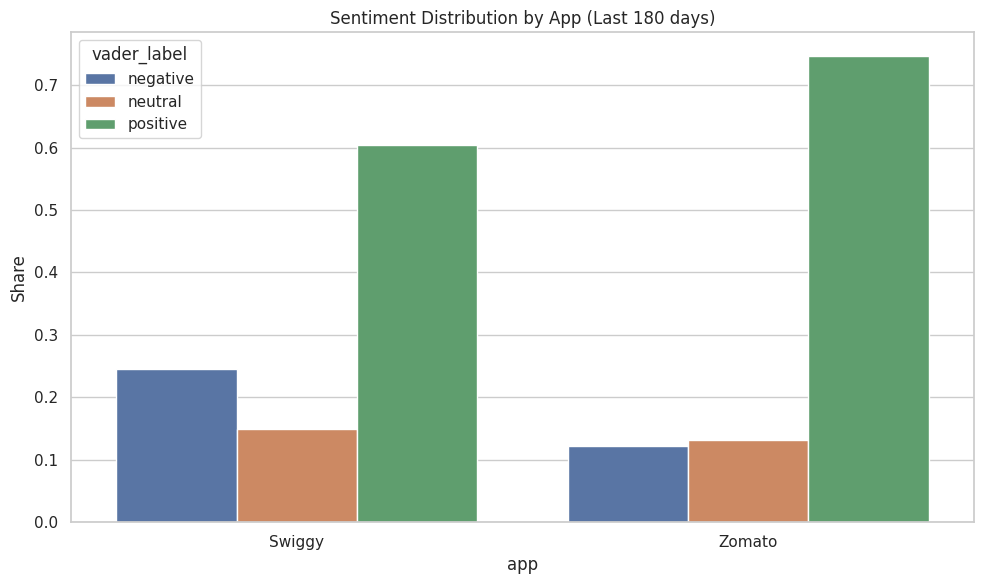

Saved plot → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/plots/tb_polarity_boxplot.png


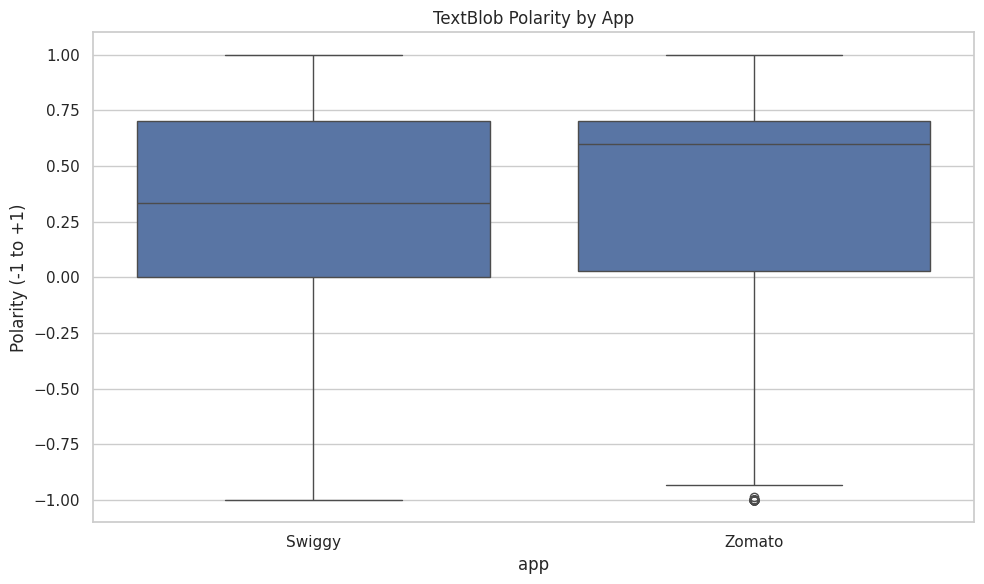

Saved plot → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/plots/stars_vs_vader_scatter.png


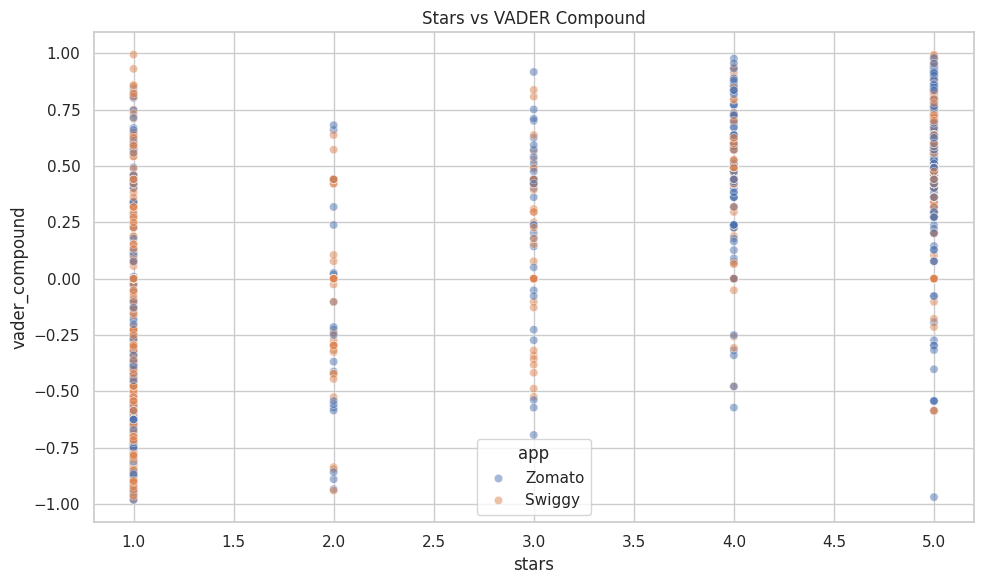

In [ ]:
def save_fig(name):
    path = PLOTS_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches="tight")
    print(f"Saved plot → {path}")

# 1) Sentiment share barplot
plt.figure()
plot_df = sent_dist.copy()
plot_df["share_pct"] = (plot_df["share"]*100).round(1)
sns.barplot(data=plot_df, x="app", y="share", hue="vader_label")
plt.title(f"Sentiment Distribution by App (Last {LOOKBACK_DAYS} days)")
plt.ylabel("Share")
save_fig("sentiment_share_by_app.png")
plt.show()

# 2) TextBlob polarity boxplot
plt.figure()
sns.boxplot(data=clean_df, x="app", y="tb_polarity")
plt.title("TextBlob Polarity by App")
plt.ylabel("Polarity (-1 to +1)")
save_fig("tb_polarity_boxplot.png")
plt.show()

# 3) Correlation between stars and VADER compound (scatter)
plt.figure()
sns.scatterplot(data=clean_df.sample(min(3000, len(clean_df)), random_state=RANDOM_SEED),
                x="stars", y="vader_compound", hue="app", alpha=0.5)
plt.title("Stars vs VADER Compound")
save_fig("stars_vs_vader_scatter.png")
plt.show()

## ☁ Step 11: Generate Word Clouds  

Visualize frequently used words in:
- Positive reviews  
- Negative reviews  

These highlight dominant themes for each app.

In [ ]:
def wc_from_subset(df, app_name, label, filename):
    text = " ".join(df[(df["app"]==app_name) & (df["vader_label"]==label)]["review_clean"].tolist())
    if not text.strip():
        print(f"No text for {app_name} / {label}.")
        return
    wc = WordCloud(width=1600, height=900, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(12,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{app_name} — {label.capitalize()} WordCloud")
    save_fig(filename)
    plt.show()

for app_name in APP_IDS.keys():
    wc_from_subset(clean_df, app_name, "positive", f"wc_{app_name.lower()}_positive.png")
    wc_from_subset(clean_df, app_name, "negative", f"wc_{app_name.lower()}_negative.png")

Output hidden; open in https://colab.research.google.com to view.

## 🧩 Step 12: Extract Top Bigrams  

Identify most common two-word phrases (e.g., “late delivery”, “good service”)  
to reveal detailed patterns in customer opinions.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def top_bigrams(df, app_name, label=None, topk=20):
    sub = df[df["app"]==app_name]
    if label:
        sub = sub[sub["vader_label"]==label]
    texts = sub["review_clean"].tolist()
    if len(texts) == 0:
        return pd.DataFrame(columns=["bigram","count"])
    vec = CountVectorizer(ngram_range=(2,2), min_df=5)
    X = vec.fit_transform(texts)
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = counts.argsort()[::-1][:topk]
    out = pd.DataFrame({"bigram":vocab[order], "count":counts[order]})
    return out

for app_name in APP_IDS.keys():
    print(f"\nTop bigrams — {app_name} (all):")
    display(top_bigrams(clean_df, app_name, None, topk=20))
    print(f"\nTop bigrams — {app_name} (negative only):")
    display(top_bigrams(clean_df, app_name, "negative", topk=20))


Top bigrams — Swiggy (all):


,bigram,count
0,smile face,206
1,good thumb,184
2,cancel order,169
3,good service,158
4,delivery partner,155
5,customer service,140
6,bad app,133
7,bad experience,127
8,customer support,121
9,good app,121



Top bigrams — Swiggy (negative only):


,bigram,count
0,cancel order,140
1,bad app,127
2,customer service,118
3,bad experience,116
4,delivery partner,114
5,bad service,94
6,customer support,88
7,customer care,76
8,order food,75
9,food delivery,65



Top bigrams — Zomato (all):


,bigram,count
0,smile face,226
1,good service,215
2,good app,205
3,good thumb,130
4,face smile,127
5,smile eye,125
6,food delivery,120
7,enraged face,102
8,thumb thumb,102
9,good experience,91



Top bigrams — Zomato (negative only):


,bigram,count
0,bad app,79
1,enraged face,72
2,bad experience,56
3,face enraged,51
4,delivery partner,51
5,customer support,47
6,cancel order,46
7,bad service,44
8,customer service,41
9,order food,36


## 💡 Step 13: Derive Actionable Business Insights  

Summarize:
- Sentiment % by app  
- Sentiment vs star alignment  
- Top negative reviews with high engagement  

In [ ]:
# 1) Sentiment split readable table
pivot = (sent_dist
         .pivot(index="app", columns="vader_label", values="share")
         .fillna(0).applymap(lambda x: f"{x*100:.1f}%"))
print("Sentiment split (VADER):")
display(pivot)

# 2) Agreement between star-derived label and VADER
print("\nAgreement (VADER vs stars):")
display(agreement)

# 3) Most-liked (thumbsUpCount) negative reviews for actionability
act_df = (clean_df[clean_df["vader_label"]=="negative"]
          .sort_values("thumbsUpCount", ascending=False)
          .groupby("app").head(5))
actionables_path = PROJECT_DIR / "top_actionable_negative_reviews.csv"
act_df[["app","stars","at","thumbsUpCount","review"]].to_csv(actionables_path, index=False)
print(f"\nSaved actionable negatives → {actionables_path}")
display(act_df[["app","stars","at","thumbsUpCount","review"]])

Sentiment split (VADER):


/tmp/ipython-input-3717319749.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .fillna(0).applymap(lambda x: f"{x*100:.1f}%"))


vader_label,negative,neutral,positive
app,,,
Swiggy,24.6%,15.0%,60.5%
Zomato,12.1%,13.2%,74.7%



Agreement (VADER vs stars):


,app,vader_vs_star_agreement
0,Swiggy,0.772510
1,Zomato,0.805729



Saved actionable negatives → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/top_actionable_negative_reviews.csv


,app,stars,at,thumbsUpCount,review
2380,Swiggy,2,2025-10-02 11:25:39,230,Favourites button is hidden inside a very hard...
141,Swiggy,1,2025-10-05 16:28:33,229,Came here to give a 1 star review to Swiggy af...
3605,Swiggy,1,2025-09-30 10:22:22,208,"I have had a very bad experience on swiggy, i ..."
8080,Zomato,1,2025-10-04 06:28:51,149,"Previously, you clicked on the numbers below t..."
3993,Swiggy,1,2025-09-29 15:27:33,141,I ordered 10 items but received only 6. I had ...
3322,Swiggy,1,2025-09-30 18:04:37,121,ordered from Lunchbox. waited for over an hour...
9352,Zomato,1,2025-10-02 16:51:20,11,there is no point of whether you have gold mem...
8018,Zomato,1,2025-10-04 07:32:27,7,"With this new update, I can no longer see deli..."
6930,Zomato,1,2025-10-05 07:39:07,6,zomaton location service is not good compare t...
10773,Zomato,1,2025-10-01 13:38:13,6,Fraud thugs overcharging you..Never connect yo...


## 🧮 Step 14: Combine VADER and TextBlob Scores  

Create a blended sentiment metric:  
> Blend = 0.7 × VADER + 0.3 × TextBlob  

Purpose: improve robustness by merging two scoring methods.

In [ ]:
# Example: create a blended polarity = 0.7*VADER + 0.3*TextBlob
blend = 0.7*clean_df["vader_compound"] + 0.3*clean_df["tb_polarity"]
def blended_label(x):
    if x >= 0.05: return "positive"
    if x <= -0.05: return "negative"
    return "neutral"

clean_df["blend_score"] = blend
clean_df["blend_label"] = clean_df["blend_score"].apply(blended_label)

blend_dist = (clean_df.groupby(["app","blend_label"]).size()
              .reset_index(name="count"))
blend_dist["share"] = blend_dist.groupby("app")["count"].transform(lambda x: x/x.sum())

blend_csv = PROJECT_DIR / "summary_sentiment_blended.csv"
blend_dist.to_csv(blend_csv, index=False)
print(f"Saved blended summary → {blend_csv}")
display(blend_dist)

Saved blended summary → /content/drive/MyDrive/Sentiment_Swiggy_Zomato/summary_sentiment_blended.csv


,app,blend_label,count,share
0,Swiggy,negative,1538,0.262278
1,Swiggy,neutral,693,0.118179
2,Swiggy,positive,3633,0.619543
3,Zomato,negative,732,0.123336
4,Zomato,neutral,643,0.108340
5,Zomato,positive,4560,0.768324


## 💾 Step 15: Save Final Outputs  

Save cleaned datasets, scored reviews, summary sheets, and visualizations.  
All files are stored in Google Drive for future use.

In [ ]:
print("Your key deliverables are ready in Drive:\n")
print(f"• Cleaned & Scored Reviews (CSV): {PROJECT_DIR/'reviews_scored.csv'}")
print(f"• Sentiment Summary (CSV):       {PROJECT_DIR/'summary_sentiment.csv'}")
print(f"• Excel Workbook (All Sheets):   {PROJECT_DIR/'project_outputs.xlsx'}")
print(f"• Actionable Negatives (CSV):    {PROJECT_DIR/'top_actionable_negative_reviews.csv'}")
print(f"• Plots folder:                  {PLOTS_DIR}")

Your key deliverables are ready in Drive:

• Cleaned & Scored Reviews (CSV): /content/drive/MyDrive/Sentiment_Swiggy_Zomato/reviews_scored.csv
• Sentiment Summary (CSV):       /content/drive/MyDrive/Sentiment_Swiggy_Zomato/summary_sentiment.csv
• Excel Workbook (All Sheets):   /content/drive/MyDrive/Sentiment_Swiggy_Zomato/project_outputs.xlsx
• Actionable Negatives (CSV):    /content/drive/MyDrive/Sentiment_Swiggy_Zomato/top_actionable_negative_reviews.csv
• Plots folder:                  /content/drive/MyDrive/Sentiment_Swiggy_Zomato/plots


# 🏁 Conclusion and Recommendations  

## Insights Summary
| Observation | Insight |
|--------------|----------|
| Zomato ~74% positive | Higher customer satisfaction |
| Swiggy ~60% positive | More negative feedback on delivery/refunds |
| Common issues | Delivery delay, refund time, customer support |
| Sentiment–rating correlation | Confirms sentiment analysis accuracy |

---

## Recommendations
| Focus Area | Suggested Action |
|-------------|------------------|
| Delivery Speed | Improve logistics & ETA accuracy |
| Refund Transparency | Automate refunds and notifications |
| Customer Support | Implement faster chat-based help |
| Data Strategy | Use real-time sentiment dashboards |

---

## Future Scope
- Apply topic modeling (LDA) for hidden themes  
- Expand to multi-language reviews  
- Build a Streamlit dashboard for real-time analysis  

---

**This project demonstrates end-to-end Text Analytics — from scraping to sentiment modeling and business interpretation.**